# Higgs Boson Detection: Comparing Neural Networks

In this project I will compare the performances of different 'size' (number of layers and number of units in those layers) Neural Networks. I was inspired to conduct this project after reading the paper: *Baldi, P., Sadowski, P. & Whiteson, D. (2014), "Searching for Exotic Particles in High-energy Physics with Deep Learning", Nature Communications* which looked at using a neural network to predict the presence of the Higgs Boson.

In the original paper a Deep Neural Network with the following properties was used:
- Five layers of $300$ Neurons each.
- Learning rate of $0.05$
- weight decay coefficient of $1e-5$

The original paper used a dataset which contains $2,600,000$ training, $500,000$ testing and $100,000$ validation examples. This dataset is unfortunately unavailable therefore I will use the [HIGGS dataset](https://archive.ics.uci.edu/ml/datasets/HIGGS) from the UCI Machine Learning Repository as an appropriate alternative! This dataset contains kinematic properties measured by the particle detectors in the accelerator, and a binary class label that distinguishes between a signal process which produces Higgs bosons and a background process which does not. I will be working with a small subset consisting of $50,000$ examples of the data in this project.

#### Goal of Project.
My goal is to compare the performance of a small, medium and paper models at classifying the presence of Higgs Boson. The paper model will follow the same architecture as the original paper. I then Look at improving the performance with regularization.

#### Notable Methods
- TensorFlow prefetched Dataset objects are utilised for training, testing and validation datasets
- Two custom CallBacks are created to print model progress and checkpoint models parameters respectively during training
- Results are plotted and evaluated.
- Regularization methods are used to combat over fitting including `BatchNormalization` and `Dropout` Layers and `l2` regularizer.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data

I will use a subset, of the orginal Higgs Dataset, which contains 50,000 examples. 

In [6]:
# I created a subset of the Higgs Dataset - which is stored in my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#load and store data in pd.DataFrame
higgs_data_path = '/content/drive/MyDrive/HIGGS-sample-extra.csv'
df = pd.read_csv(higgs_data_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.0,4.140214,-1.309068,1.379247,0.634788,-0.990745,1.584438,1.705151,-0.366938,0.000000,...,-0.510148,1.483119,3.101961,1.964873,1.502018,1.898119,3.104760,2.119824,2.020517,1.767800
1,0.0,2.264555,-0.137384,1.318212,0.958699,0.928448,0.720491,-1.042737,-0.734492,0.000000,...,-1.279677,-0.085166,0.000000,0.641225,0.732313,0.980272,0.783905,0.359036,0.755468,0.821127
2,0.0,1.237873,-1.320756,0.829379,0.958321,0.345761,0.533978,-0.460482,-1.585458,0.000000,...,-0.017950,-1.209420,0.000000,0.349277,0.730081,0.982698,0.796364,0.526482,0.835821,0.738029
3,1.0,0.946706,0.931060,-1.448987,1.006333,0.522835,0.544055,0.670360,-0.966775,1.086538,...,2.101585,-1.334275,0.000000,0.721876,1.044748,1.323438,0.849437,1.200303,0.823593,0.728583
4,1.0,0.543354,-1.610999,1.420307,1.243565,0.206824,1.282409,-1.036796,1.693223,0.000000,...,1.012252,-0.564612,0.000000,2.463745,1.441290,1.011172,0.895133,1.142160,1.259252,1.135338


In [35]:
df.shape

(50000, 29)

In [8]:
def create_dataset(dataframe):
  '''
  function to 
  * create train/validation/test splits. in 80/10/10
  * ensure dtype is float32
  * load splits in tf.data.Dataset objects
  return
  * (train, validation,test) datsets
  '''
  #easy enough just need the length of the data frame and split accordingly
  num_rows = dataframe.shape[0]
  first_split_ind = int(num_rows * 0.8)
  second_split_ind = int(num_rows*0.1) + first_split_ind

  train_ds = tf.data.Dataset.from_tensor_slices(tf.cast(dataframe[:first_split_ind], 'float32'))
  valid_ds = tf.data.Dataset.from_tensor_slices(tf.cast(dataframe[first_split_ind:second_split_ind], 'float32'))
  test_ds = tf.data.Dataset.from_tensor_slices(tf.cast(dataframe[second_split_ind:], 'float32'))

  return train_ds, valid_ds, test_ds

In [9]:
train_ds, valid_ds, test_ds = create_dataset(df)

print(train_ds.element_spec)
print(valid_ds.element_spec)
print(test_ds.element_spec)


TensorSpec(shape=(29,), dtype=tf.float32, name=None)
TensorSpec(shape=(29,), dtype=tf.float32, name=None)
TensorSpec(shape=(29,), dtype=tf.float32, name=None)


### Pre-Processing

the following functions will shuffle and batch the Datasets, and extract the input features and targets. 

In [10]:
def shuffle_n_batch(dataset, batch_size, shuffle_buffer=None):
  'shuffle and batch data based on shuffle_buffer and batch_size'

  if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size)
  return dataset

In [11]:
def map_dataset(dataset):
  """
  This function is used to map over the Dataset object to extract the input features 
  and target variable. The function takes a Dataset object, and maps over the 
  Dataset to create input features and targets
  """

  def extract_feat_n_targ(batch_of_features): #batch_of_features because we have already batched our dataset
    #all columns bar the first
    features = batch_of_features[..., 1:]
    #just the first column
    targets = batch_of_features[..., :1]
    return features, targets

  #tf.data.Dataset objs have a .map method which applies the transformation to each elem (or batch) in dataset
  return dataset.map(extract_feat_n_targ)

In [12]:
#shuffle and batch
train_ds = shuffle_n_batch(dataset=train_ds, batch_size=500, shuffle_buffer=1000)
valid_ds   = shuffle_n_batch(dataset=valid_ds, batch_size=500, shuffle_buffer=None)
test_ds  = shuffle_n_batch(dataset=test_ds, batch_size=500, shuffle_buffer=None)

#extract features
train_ds = map_dataset(train_ds)
valid_ds = map_dataset(valid_ds)
test_ds = map_dataset(test_ds)

print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [13]:
# Prefetch the Datasets

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Model

I want to see the impact of training a small, medium and large model and their effects on accuracy and computational performance.

I also am going create a custom callback to save model parameters and to print the progress of training (rather than printing out potentially 2000 epochs).

In [14]:
#check we are on GPUs

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
def get_mlp(input_shape, hidden_units):
    """
    This function is used to build the MLP model. It takes 
    input_shape  | dimemsion of the input
    hidden_units | lst containing the number of neurons in each successive Dense layer with 'selu' activation
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    h = inputs
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='selu')(h)
    outputs = tf.keras.layers.Dense(1, activation=None)(h) # no activation - leave as logits
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
def get_compile_and_fit_args():
    """
    This function is used to create the optimizer, loss, metric and callback objects as instances from the corresponding.
    """
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    acc = tf.keras.metrics.BinaryAccuracy()
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=50)
    return opt, loss, acc, earlystopping

In [17]:
# create a custom callback to checkpoint the parameters of the best model during training

class CheckpointCall(tf.keras.callbacks.Callback):

  def __init__(self, directory):
    super(CheckpointCall, self).__init__()
    self.directory = directory
    #initalise a best validation loss score
    self.best_val = tf.Variable(np.inf, trainable=False)
  
  def set_model(self, model):
    self.model = model
    self.ckpt = tf.train.Checkpoint(model=self.model)
    self.manager = tf.train.CheckpointManager(self.ckpt, self.directory, 
                                              checkpoint_name='model', max_to_keep=1)
  
  def on_epoch_end(self, epoch, logs=None):
    #get validation loss
    validation_loss = logs['val_loss']
    #check to see if val_loss is lower the previous best
    if validation_loss < self.best_val:
      #update best_val
      self.best_val = validation_loss
      #save to manager
      self.manager.save()


In [18]:
class PrintProgress(tf.keras.callbacks.Callback):
    
    def __init__(self, num_epochs, **kwargs):
        """
        The initializer should call the base class initializer, passing in any 
        optional keyword arguments passed in
        """
        super(PrintProgress, self).__init__(**kwargs)
        self.num_epochs = num_epochs
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.num_epochs == 0:
            loss_and_metrics = ', '.join(['{}: {:.4f}'.format(k, v) for k, v in logs.items()])
            print("Epoch: {}, {}".format(epoch + 1, loss_and_metrics))

In [19]:
def compile_and_fit(model, optimizer, loss, num_epochs, train_dataset, 
                    validation_dataset=None, metrics=None, callbacks=None):
    """
    This function will compile and fit the model according to the arguments specified.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    history = model.fit(train_dataset, epochs=num_epochs, verbose=0,
                        validation_data=validation_dataset, callbacks=callbacks)
    return history

In [20]:
#### get our model ####

small_model = get_mlp(input_shape=(28,), hidden_units=[16, 16])
small_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


In [21]:
#### get our compile and fit arguments ####
adam, bce_loss, bin_acc, early_stopping = get_compile_and_fit_args()

#### instantate callback ####
ckpt = CheckpointCall(directory = "./models/small")
print_progress = PrintProgress(num_epochs=10)

### compile and fit the model ####
small_history = compile_and_fit(small_model, adam, bce_loss, 2000, train_ds, 
                                validation_dataset=valid_ds, metrics=[bin_acc],
                                callbacks=[early_stopping, print_progress, ckpt])

Epoch: 10, loss: 0.6484, binary_accuracy: 0.5657, val_loss: 0.6478, val_binary_accuracy: 0.5600
Epoch: 20, loss: 0.6376, binary_accuracy: 0.5865, val_loss: 0.6383, val_binary_accuracy: 0.5752
Epoch: 30, loss: 0.6313, binary_accuracy: 0.5966, val_loss: 0.6329, val_binary_accuracy: 0.5870
Epoch: 40, loss: 0.6260, binary_accuracy: 0.6077, val_loss: 0.6282, val_binary_accuracy: 0.5984
Epoch: 50, loss: 0.6202, binary_accuracy: 0.6205, val_loss: 0.6236, val_binary_accuracy: 0.6028
Epoch: 60, loss: 0.6129, binary_accuracy: 0.6334, val_loss: 0.6168, val_binary_accuracy: 0.6174
Epoch: 70, loss: 0.6059, binary_accuracy: 0.6459, val_loss: 0.6116, val_binary_accuracy: 0.6304
Epoch: 80, loss: 0.6008, binary_accuracy: 0.6561, val_loss: 0.6079, val_binary_accuracy: 0.6410
Epoch: 90, loss: 0.5978, binary_accuracy: 0.6607, val_loss: 0.6055, val_binary_accuracy: 0.6494
Epoch: 100, loss: 0.5948, binary_accuracy: 0.6651, val_loss: 0.6046, val_binary_accuracy: 0.6474
Epoch: 110, loss: 0.5929, binary_accura

### Medium Model

In [22]:
# Build a medium-sized MLP model

medium_model = get_mlp(input_shape=(28,), hidden_units=[64, 64, 64])
medium_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_3 (Dense)             (None, 64)                1856      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


In [23]:
#### checkpoint callback object for the medium MLP model ####
ckpt = CheckpointCall("./models/medium")

### compile and fit the model ####
medium_history = compile_and_fit(medium_model, adam, bce_loss, 2000, train_ds, 
                                validation_dataset=valid_ds, metrics=[bin_acc],
                                callbacks=[early_stopping, print_progress, ckpt])

Epoch: 10, loss: 0.6026, binary_accuracy: 0.6497, val_loss: 0.6090, val_binary_accuracy: 0.6634
Epoch: 20, loss: 0.5830, binary_accuracy: 0.6748, val_loss: 0.5968, val_binary_accuracy: 0.6690
Epoch: 30, loss: 0.5723, binary_accuracy: 0.6867, val_loss: 0.5926, val_binary_accuracy: 0.6728
Epoch: 40, loss: 0.5651, binary_accuracy: 0.6923, val_loss: 0.5905, val_binary_accuracy: 0.6744
Epoch: 50, loss: 0.5572, binary_accuracy: 0.6974, val_loss: 0.5872, val_binary_accuracy: 0.6712
Epoch: 60, loss: 0.5516, binary_accuracy: 0.7019, val_loss: 0.5911, val_binary_accuracy: 0.6816
Epoch: 70, loss: 0.5464, binary_accuracy: 0.7050, val_loss: 0.5889, val_binary_accuracy: 0.6792
Epoch: 80, loss: 0.5414, binary_accuracy: 0.7094, val_loss: 0.5911, val_binary_accuracy: 0.6834
Epoch: 90, loss: 0.5370, binary_accuracy: 0.7119, val_loss: 0.5937, val_binary_accuracy: 0.6836
Epoch: 100, loss: 0.5328, binary_accuracy: 0.7150, val_loss: 0.5952, val_binary_accuracy: 0.6848
Epoch: 110, loss: 0.5283, binary_accura

### Paper Model

In [24]:
# Build a medium-sized MLP model

paper_model = get_mlp(input_shape=(28,), hidden_units=[300, 300, 300, 300, 300])
paper_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_7 (Dense)             (None, 300)               8700      
                                                                 
 dense_8 (Dense)             (None, 300)               90300     
                                                                 
 dense_9 (Dense)             (None, 300)               90300     
                                                                 
 dense_10 (Dense)            (None, 300)               90300     
                                                                 
 dense_11 (Dense)            (None, 300)               90300     
                                                                 
 dense_12 (Dense)            (None, 1)                 301 

In [25]:
# Create a checkpoint callback object for the large MLP model

ckpt = CheckpointCall("./models/large")

paper_history = compile_and_fit(paper_model, adam, bce_loss, 2000, train_ds, 
                                validation_dataset=valid_ds, metrics=[bin_acc],
                                callbacks=[early_stopping, print_progress, ckpt])

Epoch: 10, loss: 0.5653, binary_accuracy: 0.6853, val_loss: 0.6046, val_binary_accuracy: 0.6800
Epoch: 20, loss: 0.5116, binary_accuracy: 0.7303, val_loss: 0.6012, val_binary_accuracy: 0.6806
Epoch: 30, loss: 0.4517, binary_accuracy: 0.7721, val_loss: 0.6231, val_binary_accuracy: 0.6872
Epoch: 40, loss: 0.3746, binary_accuracy: 0.8202, val_loss: 0.7016, val_binary_accuracy: 0.6886
Epoch: 50, loss: 0.2721, binary_accuracy: 0.8806, val_loss: 0.8035, val_binary_accuracy: 0.6768
Epoch: 60, loss: 0.1877, binary_accuracy: 0.9226, val_loss: 1.0316, val_binary_accuracy: 0.6560


## Results

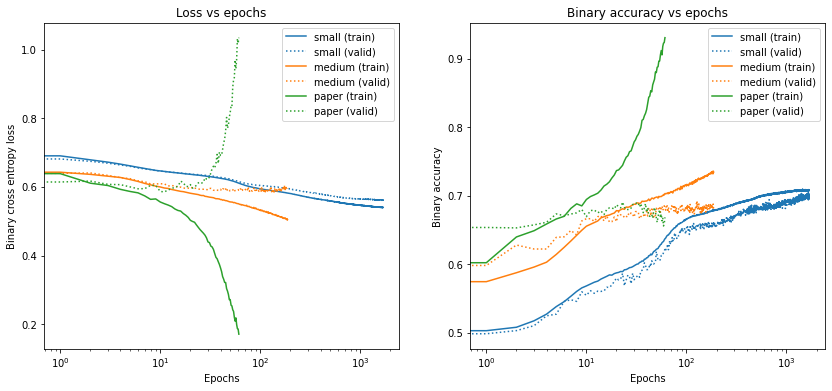

In [26]:
fig = plt.figure(figsize=(14, 6))

fig.add_subplot(121)
plt.plot(small_history.history['loss'], label='small (train)', color='C0', linestyle='-')
plt.plot(small_history.history['val_loss'], label='small (valid)', color='C0', linestyle=':')
plt.plot(medium_history.history['loss'], label='medium (train)', color='C1', linestyle='-')
plt.plot(medium_history.history['val_loss'], label='medium (valid)', color='C1', linestyle=':')
plt.plot(paper_history.history['loss'], label='paper (train)', color='C2', linestyle='-')
plt.plot(paper_history.history['val_loss'], label='paper (valid)', color='C2', linestyle=':')
plt.xscale('log')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(small_history.history['binary_accuracy'], label='small (train)', color='C0', linestyle='-')
plt.plot(small_history.history['val_binary_accuracy'], label='small (valid)', color='C0', linestyle=':')
plt.plot(medium_history.history['binary_accuracy'], label='medium (train)', color='C1', linestyle='-')
plt.plot(medium_history.history['val_binary_accuracy'], label='medium (valid)', color='C1', linestyle=':')
plt.plot(paper_history.history['binary_accuracy'], label='paper (train)', color='C2', linestyle='-')
plt.plot(paper_history.history['val_binary_accuracy'], label='paper (valid)', color='C2', linestyle=':')
plt.xscale('log')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

## Regularize the Model

There are clear signs of overfitting here - the validation accuracy remains low while the training accuracy countinues to improve. 

I will therefore regularize my model to help combact this overfitting! I will introduce batch normalization layers (which normalise the batch of inputs to the batch normalization layer - which in turn smooths the terrain of the loss function leading to better stability in the behaviour of the gradients during training. Note: a small regularization affect occurs due to the 'randomness' induced in shuffling the data into batches). I will aslo introduce dropout layers (which randomly 'zero-out' neurons during training which reduces the capacity of the network leading to a regularistion affect. Also Dropout has the important effect of preventing co-adaption between neurons (co-adaption occurs when neurons learn features of the data that are only useful/meaningful in combination with all other features that are learnt. Any neuron in the network is no longer able to depend on any other specific neurons being present, and so each neuron learns features that are more robust, and generalise better). Finally i will add l2 regularization (which adds a sum of squares penelty term to the loss function which discourages the weights becoming too large - preventing domance of certain features) 


In [27]:
def get_regularised_model(input_shape, hidden_units, l2_reg_coeff, dropout_rate):
    """
    function to build regularized model using keras Functional API
    """
    inputs = tf.keras.layers.Input(shape=input_shape)
    h = inputs
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='selu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(l2_reg_coeff))(h)
        h = tf.keras.layers.BatchNormalization()(h)
        h = tf.keras.layers.Dropout(dropout_rate)(h)
    outputs = tf.keras.layers.Dense(1, activation=None)(h)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [28]:
model_regularised = get_regularised_model(input_shape=(28,), hidden_units=[300, 300, 300, 300, 300],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
model_regularised.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_13 (Dense)            (None, 300)               8700      
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_14 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                           

In [29]:
#### create checkpoint call back ###
ckpt = CheckpointCall("./models/huge")

regularised_history = compile_and_fit(model_regularised, adam, bce_loss, 2000, train_ds, 
                                validation_dataset=valid_ds, metrics=[bin_acc],
                                callbacks=[early_stopping, print_progress, ckpt])

Epoch: 10, loss: 0.7165, binary_accuracy: 0.6258, val_loss: 0.6977, val_binary_accuracy: 0.6554
Epoch: 20, loss: 0.6617, binary_accuracy: 0.6550, val_loss: 0.6514, val_binary_accuracy: 0.6544
Epoch: 30, loss: 0.6314, binary_accuracy: 0.6654, val_loss: 0.6211, val_binary_accuracy: 0.6646
Epoch: 40, loss: 0.6109, binary_accuracy: 0.6711, val_loss: 0.6016, val_binary_accuracy: 0.6676
Epoch: 50, loss: 0.6007, binary_accuracy: 0.6755, val_loss: 0.5918, val_binary_accuracy: 0.6824
Epoch: 60, loss: 0.5936, binary_accuracy: 0.6806, val_loss: 0.5856, val_binary_accuracy: 0.6842
Epoch: 70, loss: 0.5894, binary_accuracy: 0.6811, val_loss: 0.5819, val_binary_accuracy: 0.6772
Epoch: 80, loss: 0.5864, binary_accuracy: 0.6838, val_loss: 0.5777, val_binary_accuracy: 0.6798
Epoch: 90, loss: 0.5840, binary_accuracy: 0.6878, val_loss: 0.5777, val_binary_accuracy: 0.6844
Epoch: 100, loss: 0.5824, binary_accuracy: 0.6870, val_loss: 0.5764, val_binary_accuracy: 0.6860
Epoch: 110, loss: 0.5807, binary_accura

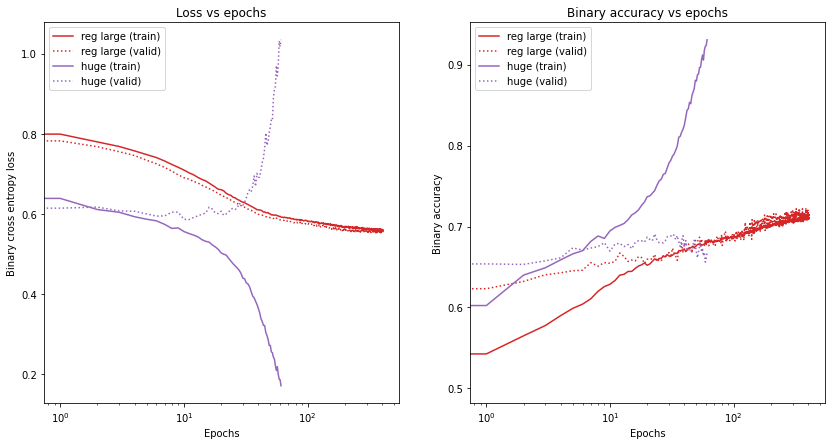

In [30]:
# Plot the performance of the huge model and large regularised model

fig = plt.figure(figsize=(14, 7))

fig.add_subplot(121)
plt.plot(regularised_history.history['loss'], label='reg large (train)', color='C3', linestyle='-')
plt.plot(regularised_history.history['val_loss'], label='reg large (valid)', color='C3', linestyle=':')
plt.plot(paper_history.history['loss'], label='huge (train)', color='C4', linestyle='-')
plt.plot(paper_history.history['val_loss'], label='huge (valid)', color='C4', linestyle=':')
plt.xscale('log')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(regularised_history.history['binary_accuracy'], label='reg large (train)', color='C3', linestyle='-')
plt.plot(regularised_history.history['val_binary_accuracy'], label='reg large (valid)', color='C3', linestyle=':')
plt.plot(paper_history.history['binary_accuracy'], label='huge (train)', color='C4', linestyle='-')
plt.plot(paper_history.history['val_binary_accuracy'], label='huge (valid)', color='C4', linestyle=':')
plt.xscale('log')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()

The effects of regularation are very clear - with both the loss and accuracy on the validation and training datasets moving in parrallel! Our model is therefore robost and generalises well

In [34]:
# Collect evaluation loss and metrics for each model


saved_models = {
    'small': {"build_fn": get_mlp, "args": {"input_shape": (28,), "hidden_units": [16, 16]}},
    'medium': {"build_fn": get_mlp, "args": {"input_shape": (28,), "hidden_units": [64, 64, 64]}},
    'large': {"build_fn": get_mlp, "args": {"input_shape": (28,), "hidden_units": [300, 300, 300, 300, 300]}},
    'huge': {"build_fn": get_regularised_model, "args": {
        "input_shape": (28,), "hidden_units": [300, 300, 300, 300, 300],
        "l2_reg_coeff": 0.0001, "dropout_rate": 0.5
    }},
}

evaluation = {"Model": [], "Test loss": [], "Test accuracy": []}
for model_size, options in saved_models.items():
    model = options['build_fn'](**options['args'])
    adam, bce_loss, bin_acc, _ = get_compile_and_fit_args()
    model.compile(loss=bce_loss, optimizer=adam, metrics=[bin_acc])
    status = tf.train.Checkpoint(model=model).restore(tf.train.latest_checkpoint('./models/{}'.format(model_size))).expect_partial()
    status.assert_existing_objects_matched()
    results = model.evaluate(test_ds, return_dict=True, verbose=0)
    evaluation["Model"].append(model_size)
    evaluation["Test loss"].append(results['loss'])
    evaluation["Test accuracy"].append(results['binary_accuracy'])

#save to df   
results_df = pd.DataFrame(evaluation)
#change model names
results_df.at[2, 'Model'] = 'Paper'
results_df.at[3, 'Model'] = 'Paper Regularised'
results_df.set_index('Model', inplace=True)
results_df

,Test loss,Test accuracy
Model,,
small,0.574433,0.6874
medium,0.589756,0.6772
Paper,0.601072,0.6788
Paper Regularised,0.558958,0.7156


# Final Thoughts

Clearly our results have improved from the small model to the paper regularized model - however the results are relatively poor and accuracy on the test set of 0.7156 isnt that impressive. 

There are a number of points that could improve the performance:

* Fisrtly, using cross validation to obtain the optimal hyper parameters for the model. I this project most of the parameters where chosen through intuition or through those used in the paper. Therefore there should be some improvement by finding the optimal parameters - this includes the number of neurons and hyperparameters such as the learning rate, dropout_rate, l2_reg_coeff, ...

* Secondly, using more data, I only used a small subset of the orginal HIGGS dataset. Adding more data will have a profound affect on performance because the model is able to learn the features of the data more accurately and even find new features. Additionally using a small subset has the poteintial of causing the model to be biased towards that subset - this is why we use validation and tests sets, to illistrate overfitting to the training set and hence this same problem could be occuring for the whole subset - prehaps the subset is biased in its recordings and as such adding more data will open the model to new features! More data also allows the model to hone in on the current features it has learnt more accurately, which will improve its robustness and its ability to generalise.




